# Importing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

import datetime

In [2]:
# Source: http://web.mta.info/developers/turnstile.html

def get_data_parse_dt(week_nums):
    '''
    Return dataframe containing 
    '''
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url, parse_dates=[['DATE','TIME']], keep_date_col=True))
    return pd.concat(dfs)
        
week_nums = [190601, 190608, 190615, 190622]
turnstiles_df = get_data_parse_dt(week_nums)

In [3]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]

In [4]:
turnstiles_df.DATE.value_counts().sort_index()

05/25/2019    28855
05/26/2019    29063
05/27/2019    29068
05/28/2019    28873
05/29/2019    29095
05/30/2019    29190
05/31/2019    29651
06/01/2019    29066
06/02/2019    28968
06/03/2019    30022
06/04/2019    29513
06/05/2019    29484
06/06/2019    29213
06/07/2019    28745
06/08/2019    29030
06/09/2019    29133
06/10/2019    29351
06/11/2019    29113
06/12/2019    30023
06/13/2019    29276
06/14/2019    29008
06/15/2019    29605
06/16/2019    29322
06/17/2019    29421
06/18/2019    29599
06/19/2019    29614
06/20/2019    29556
06/21/2019    30360
Name: DATE, dtype: int64

In [5]:
from datetime import datetime as dt

In [6]:
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
193647,N045,R187,01-00-00,81 ST-MUSEUM,2019-06-01 17:00:00,2
677709,R290,R161,00-00-00,KINGSBRIDGE RD,2019-06-07 05:00:00,2
193652,N045,R187,01-00-00,81 ST-MUSEUM,2019-06-02 17:00:00,2
581857,R174,R034,00-00-02,125 ST,2019-06-08 00:00:00,2
581688,R174,R034,00-00-01,125 ST,2019-06-08 00:00:00,2


In [7]:
turnstiles_df.DESC.value_counts()

REGULAR       818249
RECOVR AUD      2968
Name: DESC, dtype: int64

In [8]:
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [9]:
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-05-25 00:00:00,1
547474,R139,R031,04-00-01,34 ST-PENN STA,2019-05-26 20:00:00,1
547464,R139,R031,04-00-01,34 ST-PENN STA,2019-05-25 04:00:00,1
547465,R139,R031,04-00-01,34 ST-PENN STA,2019-05-25 08:00:00,1
547466,R139,R031,04-00-01,34 ST-PENN STA,2019-05-25 12:00:00,1


In [10]:
# Drop Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
entries_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")

#### Keeping LINENAME in Dataframe
##### Distinguishing between different stations with the same station name

In [11]:
entries_daily = (entries_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME", "DATE"],as_index=False)
                        .ENTRIES.first())

In [12]:
entries_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,NQR456W,05/25/2019,7072456
1,A002,R051,02-00-00,59 ST,NQR456W,05/26/2019,7073114
2,A002,R051,02-00-00,59 ST,NQR456W,05/27/2019,7073837
3,A002,R051,02-00-00,59 ST,NQR456W,05/28/2019,7075260
4,A002,R051,02-00-00,59 ST,NQR456W,05/29/2019,7076789


In [13]:
# 23 St is curious.  Since there are multiple 23 St stations in different locations,
# the code below pulls out the line names to help distinguish between them.

entries_daily[entries_daily['STATION'] == '23 ST']['LINENAME'].unique()

array(['NRW', 'CE', 'FM', '1', '6'], dtype=object)

Active '23 ST' stations, based on Wiki

* 23rd Street station (IRT Lexington Avenue Line), a subway station at Park Avenue South (4th Avenue) in Manhattan
* 23rd Street station (BMT Broadway Line), a subway station at Broadway and Fifth Avenue in Manhattan
* 23rd Street station (IND Sixth Avenue Line), a subway station at Sixth Avenue (Avenue of the Americas) in Manhattan
* 23rd Street station (IRT Broadway–Seventh Avenue Line), a subway station at Seventh Avenue in Manhattan
* 23rd Street station (IND Eighth Avenue Line), a subway station at Eighth Avenue in Manhattan
* Court Square–23rd Street station, a subway station near One Court Square in Long Island City, Queens

In [14]:
# Creates the PREV_DATE and PREV_ENTRIES columns, by grouping by the appropriate identifiers,
# and then applying a lambda function to shift the entries for the new columns down by one row.


entries_daily[["PREV_DATE", "PREV_ENTRIES"]] = (entries_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

/Users/wasilaq/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [15]:
# The first column now has na values, since there is no prior data to shift down.
# This drops the earliest entry in the df containing the na values.

entries_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [16]:
# Uses a conditional to select those rows where the cumulative entries are less than that for 
# for the day prior

entries_daily[entries_daily["ENTRIES"] < entries_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
2157,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,05/26/2019,1238366337,05/25/2019,1.238369e+09
2158,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,05/27/2019,1238364310,05/26/2019,1.238366e+09
2159,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,05/28/2019,1238360334,05/27/2019,1.238364e+09
2160,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,05/29/2019,1238356306,05/28/2019,1.238360e+09
2161,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,05/30/2019,1238352363,05/29/2019,1.238356e+09


In [17]:
# Applies a mask to see more granular data on a specific turnstile on a specfic day to better see
# what may be going on

mask = ((entries_df["C/A"] == "A025") & 
(entries_df["UNIT"] == "R023") & 
(entries_df["SCP"] == "01-03-01") & 
(entries_df["STATION"] == "34 ST-HERALD SQ") &
(entries_df["DATE_TIME"].dt.date == datetime.datetime(2019, 5, 26).date()))
entries_df[mask].head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES
3269,2019-05-26 20:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,20:00:00,1238366337
3268,2019-05-26 16:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,16:00:00,1238366929
3267,2019-05-26 12:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,12:00:00,1238367347
3266,2019-05-26 08:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,08:00:00,1238367539
3265,2019-05-26 04:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,04:00:00,1238367622


In [18]:
# Well, there's definitely a problem.  Let's see how many stations have suffer from it by applying
# .size()

(entries_daily[entries_daily["ENTRIES"] < entries_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME"])
    .size())

C/A   UNIT  SCP       STATION          LINENAME 
A025  R023  01-03-01  34 ST-HERALD SQ  BDFMNQRW     27
A037  R170  05-00-00  14 ST-UNION SQ   LNQR456W      1
A043  R462  00-06-00  CANAL ST         JNQRZ6W       1
A049  R088  02-05-00  CORTLANDT ST     RNW          24
A066  R118  00-00-00  CANAL ST         JNQRZ6W      27
                                                    ..
R610  R057  00-04-01  ATL AV-BARCLAY   2345BDNQR     1
R621  R060  00-03-01  EASTN PKWY-MUSM  23            2
R622  R123  00-00-00  FRANKLIN AV      2345S        27
R646  R110  01-00-01  FLATBUSH AV-B.C  25           27
R730  R431  00-00-04  EASTCHSTER/DYRE  5            27
Length: 416, dtype: int64

In [19]:


def get_daily_counts(row, max_counter):
    """This function corrects entries for the current day that are erroneously reported as lower than 
    the day prior. Function takes a row and max_counter argument, which utilizes an apply function to
    allow it to handle multiple rows.  As a safeguard, the max_counter is an upper threshold of 
    acceptability to test after the correction is made.  The max_counter should be set to a high level, 
    so that an entry value would almost certainly be erroneous if at that level.  In that case, the 
    value is set to 0"""
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Presumes that the counter is reversed, so converts it to a positive number.          
        counter = -counter
    if counter > max_counter:
        # For situations where it is believed the cumulative counter was reset.  Takes the min of the two.
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Final fail safe to ensure that the value is not outlandish.  If it is, sets to 0.
        return 0
    return counter

# Sets the max counter value (here 500,000), and applies the function above to modify if necessary
# the rows of the DAILY_ENTRIES column.
entries_daily["DAILY_ENTRIES"] = entries_daily.apply(get_daily_counts, axis=1, max_counter=500000)



617 3124306.0
1376283 8703.0
371 4317056.0
1790 13967417.0
221 7246254.0
4050694 5902992.0
7246468 4050451.0
5571815 104607574.0
459063 4526857.0
0 966871.0
852339 658.0
228 1393341.0
286 3466273.0
1828703861 9687851.0
126 4086499.0
1834 2588198.0
1337 4676887.0
607 621485338.0
149 1252883.0
216 728932.0
553 883514.0
580 1650137.0
471 796882.0
820 1523029.0
375 936362.0
366 1047791.0
761 564967.0
932 607519.0
840 1251816.0
634 1572569.0
572 527380.0
857 3126422.0
1113 1946726.0
1057 1214910.0
1154 968173.0
594 533833.0
291 1309224.0
215 778553.0
89 556763.0
1484 1063313.0
1924 852022.0
1317 2409654.0
1060 1093122.0
950 869016.0
1 618239.0
478 975675.0
1061 1461284.0
1472 1054311.0
1088 2725203.0
2095 2041280.0
1 1910177.0
212 1003601.0
531 3209791.0
2452 1395536.0
2094 2286050.0
238 733761.0
1958 1696178.0
1977 1058528.0
2019 987950.0
0 1078800.0
2291 907453.0
2257 2792918.0
97 540908.0
103 535011.0
1692 558863.0
1787 608348.0
14 1327005.0
1338 1427069.0
393281 1661809141.0
4059 155784

In [20]:
entries_daily.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,NQR456W,05/26/2019,7073114,05/25/2019,7072456.0,658.0
2,A002,R051,02-00-00,59 ST,NQR456W,05/27/2019,7073837,05/26/2019,7073114.0,723.0
3,A002,R051,02-00-00,59 ST,NQR456W,05/28/2019,7075260,05/27/2019,7073837.0,1423.0
4,A002,R051,02-00-00,59 ST,NQR456W,05/29/2019,7076789,05/28/2019,7075260.0,1529.0
5,A002,R051,02-00-00,59 ST,NQR456W,05/30/2019,7078273,05/29/2019,7076789.0,1484.0
6,A002,R051,02-00-00,59 ST,NQR456W,05/31/2019,7079862,05/30/2019,7078273.0,1589.0
7,A002,R051,02-00-00,59 ST,NQR456W,06/01/2019,7080817,05/31/2019,7079862.0,955.0
8,A002,R051,02-00-00,59 ST,NQR456W,06/02/2019,7081567,06/01/2019,7080817.0,750.0
9,A002,R051,02-00-00,59 ST,NQR456W,06/03/2019,7082949,06/02/2019,7081567.0,1382.0
10,A002,R051,02-00-00,59 ST,NQR456W,06/04/2019,7084565,06/03/2019,7082949.0,1616.0


In [21]:
# Now we can remove the PREV_ENTRIES, PREV_DATE, and ENTRIES columns, since we are concerned
# with the derived values in the DAILY_ENTRIES column

entries_daily_new = entries_daily.drop(['PREV_ENTRIES', 'ENTRIES', 'PREV_DATE'], axis = 1, errors = 'ignore')

In [23]:
# Takes z-scores for the daily entries.  In reviewing the code now, it seems that z-scores should have
# been taken for each station individually, while this code appear to derive z scores from the entire mass
# of stations at once.
# A pythonic way to tackle this correctly would be highly useful.

entries_daily_new['Z-SCORE'] = np.abs(stats.zscore(entries_daily_new['DAILY_ENTRIES']))

In [24]:
# Summary statistics on the Z-scores.  The existence of absurdly high z-score values make much more sense in light of the 
# above issue.
entries_daily_new['Z-SCORE'].describe()

count    131143.000000
mean          0.137724
std           0.990474
min           0.000056
25%           0.051411
50%           0.100763
75%           0.152242
max          61.223994
Name: Z-SCORE, dtype: float64

In [25]:
# Getting an idea of how many daily entries with a z-score above 1 exist.

entries_daily_new[(entries_daily_new['Z-SCORE'] > 1)]

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_ENTRIES,DAILY_ENTRIES,Z-SCORE
4516,A043,R462,00-06-00,CANAL ST,JNQRZ6W,06/02/2019,458941,950058.0,491117.0,60.598100
10140,B020,R263,00-03-00,AVENUE H,BQ,06/07/2019,62,185793.0,185731.0,22.816067
12123,B028,R136,01-00-01,SHEEPSHEAD BAY,BQ,06/02/2019,331,40780.0,40449.0,4.841932
23879,J001,R460,01-06-02,MARCY AV,JMZ,06/16/2019,417,127761.0,127344.0,15.592490
26681,JFK02,R535,01-00-03,HOWARD BCH JFK,A,06/18/2019,196,11780.0,11584.0,1.270785
...,...,...,...,...,...,...,...,...,...,...
111949,R287,R244,00-06-00,BURNSIDE AV,4,06/14/2019,370,274488.0,274118.0,33.751213
120408,R501,R054,00-00-01,5 AVE,7BDFM,06/08/2019,3414803,3401021.0,13782.0,1.542719
120431,R501,R054,00-00-02,5 AVE,7BDFM,06/08/2019,991388435,991377089.0,11346.0,1.241340
120592,R501,R054,00-06-01,5 AVE,7BDFM,06/08/2019,136172668,136157920.0,14748.0,1.662232


In [26]:
#Examining the columns and data types

entries_daily_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131143 entries, 1 to 136027
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   C/A            131143 non-null  object 
 1   UNIT           131143 non-null  object 
 2   SCP            131143 non-null  object 
 3   STATION        131143 non-null  object 
 4   LINENAME       131143 non-null  object 
 5   DATE           131143 non-null  object 
 6   ENTRIES        131143 non-null  int64  
 7   PREV_ENTRIES   131143 non-null  float64
 8   DAILY_ENTRIES  131143 non-null  float64
 9   Z-SCORE        131143 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 11.0+ MB


In [27]:
entries_daily_new.DAILY_ENTRIES.describe()

count    131143.000000
mean       1312.451759
std        8082.867600
min           0.000000
25%         269.000000
50%         799.000000
75%        1564.000000
max      496176.000000
Name: DAILY_ENTRIES, dtype: float64

In [28]:
entries_daily_clean = entries_daily_new[(entries_daily_new['Z-SCORE'] < 2)]

### Daily Entries for Top Stations

In [29]:
#array of top 50 stations
top_stations = entries_daily_clean.groupby(['STATION','LINENAME']).sum().sort_values('DAILY_ENTRIES', ascending = False).head(50).index[0:50]

top_stations

MultiIndex([('GRD CNTRL-42 ST',        '4567S'),
            ('34 ST-HERALD SQ',     'BDFMNQRW'),
            ('42 ST-PORT AUTH', 'ACENQRS1237W'),
            ( '34 ST-PENN STA',          'ACE'),
            ( '14 ST-UNION SQ',     'LNQR456W'),
            ( 'TIMES SQ-42 ST', '1237ACENQRSW'),
            (      'FULTON ST',     '2345ACJZ'),
            ( '47-50 STS ROCK',         'BDFM'),
            (  'FLUSHING-MAIN',            '7'),
            ( '59 ST COLUMBUS',        'ABCD1'),
            (   'PATH NEW WTC',            '1'),
            ('JKSN HT-ROOSVLT',        'EFMR7'),
            ( '34 ST-PENN STA',       '123ACE'),
            (       'CANAL ST',      'JNQRZ6W'),
            ( 'W 4 ST-WASH SQ',      'ABCDEFM'),
            (          '86 ST',          '456'),
            ('42 ST-BRYANT PK',        'BDFM7'),
            (          '59 ST',      '456NQRW'),
            ('LEXINGTON AV/53',          'EM6'),
            (          '96 ST',          '123'),
            (       

In [30]:
import seaborn as sns

In [31]:
stations_daily = \
(entries_daily_clean.groupby(['STATION','LINENAME','DATE'])['DAILY_ENTRIES'].sum()
                 .reset_index())

stations_daily.head()

,STATION,LINENAME,DATE,DAILY_ENTRIES
0,1 AV,L,05/26/2019,5172.0
1,1 AV,L,05/27/2019,4808.0
2,1 AV,L,05/28/2019,16825.0
3,1 AV,L,05/29/2019,18800.0
4,1 AV,L,05/30/2019,18948.0


In [32]:
# then get top 10 stations by daily volume 
# (sum across all days is a reasonable way to define this)
top10_stations = \
    (stations_daily.groupby(['STATION','LINENAME'])['DAILY_ENTRIES'].sum()
                   .reset_index()
                   .sort_values(by='DAILY_ENTRIES',ascending=False)[['STATION','LINENAME']].head(11))

top10_manhattan = top10_stations[(top10_stations['STATION'] != 'FLUSHING-MAIN')]

top10_manhattan

,STATION,LINENAME
312,GRD CNTRL-42 ST,4567S
90,34 ST-HERALD SQ,BDFMNQRW
103,42 ST-PORT AUTH,ACENQRS1237W
94,34 ST-PENN STA,ACE
28,14 ST-UNION SQ,LNQR456W
448,TIMES SQ-42 ST,1237ACENQRSW
302,FULTON ST,2345ACJZ
107,47-50 STS ROCK,BDFM
126,59 ST COLUMBUS,ABCD1
404,PATH NEW WTC,1


In [33]:
# next create a new df that filters the stations daily data down
# to the top 10 stations
stations_daily_top10 = \
    stations_daily[stations_daily['STATION'].isin(top10_manhattan['STATION'])]

In [34]:
stations_daily_top10

,STATION,LINENAME,DATE,DAILY_ENTRIES
715,14 ST-UNION SQ,456LNQRW,05/26/2019,18321.0
716,14 ST-UNION SQ,456LNQRW,05/27/2019,16989.0
717,14 ST-UNION SQ,456LNQRW,05/28/2019,29121.0
718,14 ST-UNION SQ,456LNQRW,05/29/2019,31089.0
719,14 ST-UNION SQ,456LNQRW,05/30/2019,31779.0
...,...,...,...,...
12117,TIMES SQ-42 ST,ACENQRS1237W,06/17/2019,15557.0
12118,TIMES SQ-42 ST,ACENQRS1237W,06/18/2019,17615.0
12119,TIMES SQ-42 ST,ACENQRS1237W,06/19/2019,17316.0
12120,TIMES SQ-42 ST,ACENQRS1237W,06/20/2019,17207.0


In [35]:
#dt.weekday(pd.to_datetime(stations_daily_top10['DATE']))

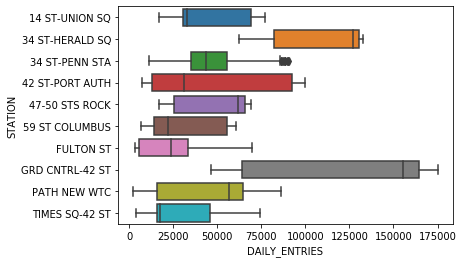

In [36]:
# use seaborn to create a boxplot by station
# with countermax set to 10000000
sns.boxplot('DAILY_ENTRIES', 'STATION', data=stations_daily_top10)

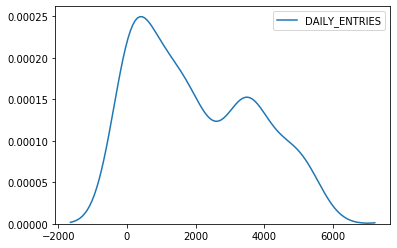

In [37]:
sns.kdeplot(entries_daily_clean[(entries_daily_clean['STATION'] == '14 ST-UNION SQ') & 
                                  (entries_daily_clean['LINENAME'] == '456LNQRW')]['DAILY_ENTRIES'])